# Deep Learning Challenge

## Preamble
The following code downloads and imports all necessary files and modules into the virtual machine of Colab. Please make sure to execute it before solving this exercise.

In [14]:
import sys, os
if 'google.colab' in sys.modules:
    if os.getcwd() == '/content':
        !git clone 'https://github.com/inb-luebeck/cs5450.git'
        os.chdir('cs5450')

In [15]:
#making sure livelossplot is installed
try:
    import livelossplot
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install livelossplot==0.4.1

#making sure huggingface datasets is installed
try:
    import datasets
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install datasets

## Setup
This exercise can utilize GPU acceleration. If you are using Google Colab you can enable access to a cloud GPU by selecting from the menu above:

**Runtime > Change runtime type > Hardware accelerator > GPU**

If you are running this notebook on your own machine, GPU acceleration is available if you have an Nvidia GPU and a CUDA-enabled driver installed. Otherwise calculations will run on the CPU.

## Real Cats vs AI-Generated Cats
In this exercise, we will use deep learning to solve a real-world problem: classifying whether a given cat photo is real or ai generated. To make things more interesting, this exercise sheet will be carried out as a competition.

You are given a dataset of 900 labeled cat photos with labels "fake" (0) or "real" (1), as well as 86 test images without labels*.

The next cells provide code to get you started. It contains a fully functional implementation of a simple convolutional neural network (CNN). It has a baseline accuracy of ~74% on the validation set.

Your task is to modify or extend the code in order to optimize the classification capabilities of the network.

The output of the network is a class-score:
- The more negative the output, the more confident the model is that the sample should be classified as class 0 (fake).
- The more positive the output, the more confident the model is that the sample should be classified as class 1 (real).
- A score of 0 means the model is undecided (which will be treated as predicted class 1 in the accuracy calculation).

The class-score is mapped to a class-probability using the sigmoid function. However, for better numerical stability the sigmoid function is already built-in into the `BCEWithLogitsLoss` loss function that is used here, so you don't need to apply sigmoid to the network output during loss calculation.

<sub>\*The **test set** labels stored in the dataset are dummy labels, not the actual labels.</sub>

### Competition rules:
The network has to be trained from scratch (i.e. no pretrained neural network that was already trained on other data) and training is only allowed with the provided data, no external datasets.

The winning team is determined based on the test set accuracy.

## Hints
In case you are struggeling with the task, here are some helpful tips and hints how the classifier could be improved:
1. Useful pytorch [overview](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py).
2. Adjust the hyperparameters for the training.
3. [Augment](https://pytorch.org/docs/stable/torchvision/transforms.html) the training data (e.g., mirroring).
4. Make the network deeper (e.g. more convolution layers or add other layers or change the channel count).
5. Regularize your network (e.g. with dropout layers or weight decay).
6. Use cross-validation instead of a fixed train-validation split.
7. Train multiple networks and combine them in an ensemble.
8. Adjust the batch size.
9. Change the learning rate and/or weight decay over the course of the training (see `update_learning_rate` below).

## Further notes and remarks:
1. Each team has to choose a team name. This will be the anonymous identifier when
the competition results are published.

In [16]:
# Data loading and preparation

from datasets import load_dataset, DatasetDict
import torch
from torch.utils.data import Dataset
from torchvision import transforms

# load the dataset from huggingface (https://huggingface.co/datasets/MMM-J/real-vs-fake-cats)
ds = load_dataset('MMM-J/real-vs-fake-cats', keep_in_memory=True)
ds_orig = ds # keeping a copy of the original un-transformed dataset to display some samples

def transformations(sample):
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts images to (C, H, W) format and scales pixel values to [0, 1]
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Example normalization step
    ])
    sample["pixel_values"] = [transform(image.convert("RGB").resize((112, 112))) for image in sample["image"]]
    return sample

ds = ds.map(transformations, keep_in_memory=True, batched=True, remove_columns=["image"])

train_val_split = ds['train'].train_test_split(test_size=0.2, seed=42)
ds = DatasetDict({
    'train': train_val_split['train'],
    'val': train_val_split['test'],
    'test': ds['test'],
})

device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
print(f"Using device type: {device_type}")
ds = ds.with_format("torch", device=device)


class InMemoryDataset(Dataset):
    def __init__(self, dataset):
        super(InMemoryDataset, self).__init__()

        self.data = dataset['pixel_values']
        self.labels = dataset['label']

    def __getitem__(self, index):
        return {'pixel_values': self.data[index], 'label': self.labels[index]}

    def __len__(self):
        return self.data.shape[0]

# Since the dataset fits into memory, we keep it there to remove the data loading bottleneck
train_data = InMemoryDataset(ds['train'])
val_data = InMemoryDataset(ds['val'])

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/86 [00:00<?, ? examples/s]

Using device type: cuda


Label: real


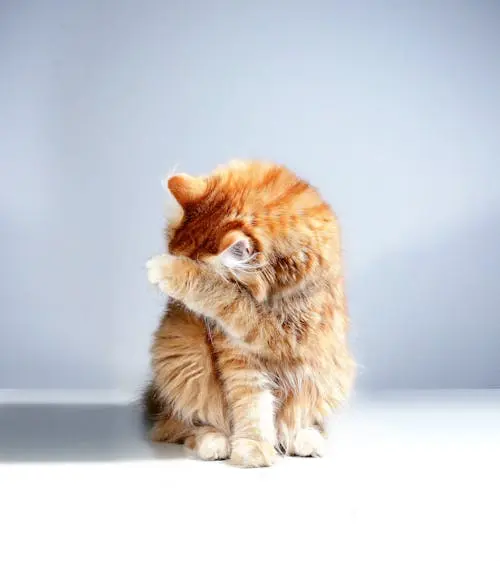

Label: fake


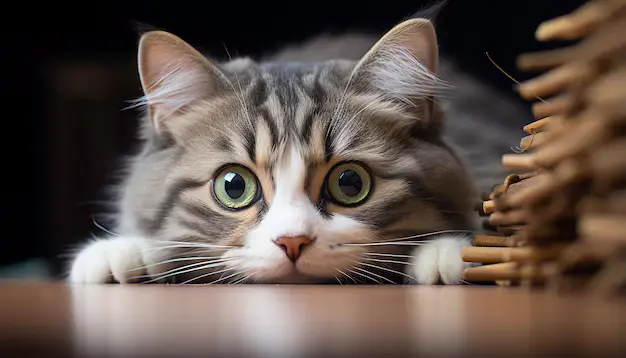

In [17]:
def label_to_string(label):
  return ds_orig["train"].info.features["label"].int2str(label)

# Show real a sample
sample_index = 453
# Get the training sample for that index
sample = ds_orig["train"][sample_index]
# Print the label string
print("Label: " + label_to_string(sample["label"]))
# Display the image
display(sample["image"])


# Show fake a sample
sample_index = 182
# Get the training sample for that index
sample = ds_orig["train"][sample_index]
# Print the label string
print("Label: " + label_to_string(sample["label"]))
# Display the image
display(sample["image"])

In [22]:
# The Neural Network architecture

import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from livelossplot import PlotLosses

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv0 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2, padding=1)
        self.relu0 = nn.LeakyReLU()

        self.adaptPool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(8, 1)

    def forward(self, x):
        x = self.conv0(x)
        x = self.relu0(x)
        x = self.adaptPool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x[:, 0]

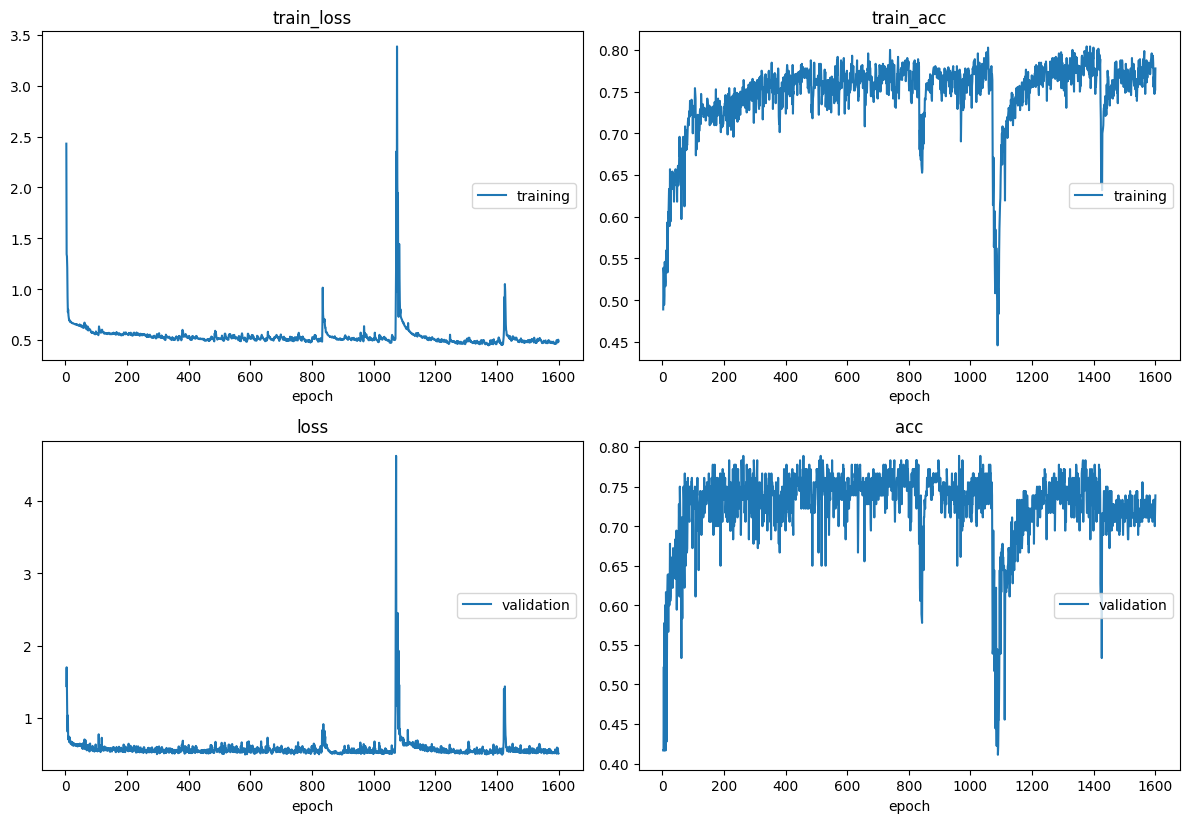

100%|██████████| 1600/1600 [00:56<00:00, 28.17it/s]


Final training accuracy: 0.7777777777777778
Final validation accuracy: 0.7388888888888889


In [23]:
# Hyperparameters
learning_rate = 0.5
weight_decay = 0
epochs = 1600
batch_size = 256

# Model and optimizer setup
torch.manual_seed(42)

model = ConvNet().to(device)
parameters = model.parameters()
loss_func = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(
        parameters,
        lr=learning_rate,
        weight_decay=weight_decay
    )

# Utility function to change the learning rate during training
def update_learning_rate(new_lr):
    for g in optimizer.param_groups:
        g['lr'] = new_lr

class StatsTracker:
    def __init__(self):
        self.loss = 0
        self.acc = 0
        self.total_sample_count = 0

    def update(self, new_loss, new_corrects, sample_count):
        new_total_sample_count = self.total_sample_count + sample_count
        self.loss = (self.loss * self.total_sample_count + new_loss * sample_count) / new_total_sample_count
        self.acc = (self.acc * self.total_sample_count + new_corrects) / new_total_sample_count

        self.total_sample_count = new_total_sample_count

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False)

liveloss = PlotLosses(plot_extrema=False)
for epoch in tqdm(range(epochs)):
    # training
    model.train()
    train_stats = StatsTracker()
    for batch_idx, batch in enumerate(train_loader):
        out = model(batch['pixel_values'])
        loss = loss_func(out, batch['label'].float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # track loss and accuracy
        preds = (torch.sigmoid(out) >= .5).float()
        corrects = torch.sum(preds == batch['label']).cpu().item()
        train_stats.update(loss.cpu().item(), corrects, len(batch['label']))

    logs = {
        'train_loss': train_stats.loss,
        'train_acc': train_stats.acc
    }

    # evaluation on the validation set
    model.eval()
    val_stats = StatsTracker()
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            out = model(batch['pixel_values'])
            loss = loss_func(out, batch['label'].float())

            # track loss and accuracy
            preds = (torch.sigmoid(out) >= .5).float()
            corrects = torch.sum(preds == batch['label']).cpu().item()
            val_stats.update(loss.cpu().item(), corrects, len(batch['label']))

    # log the loss and accuracy on the training and validation data
    logs = {
        **logs,
        'val_loss': val_stats.loss,
        'val_acc': val_stats.acc
    }

    liveloss.update(logs)

    # draw the graphs only on every 50th epoch to reduce the performance penalty by the visualization during training
    if (epoch + 1) % 50 == 0:
        liveloss.draw()

print(f"\nFinal training accuracy: {train_stats.acc}\nFinal validation accuracy: {val_stats.acc}")


In [20]:
# Make predictions for the test set

# TODO: pick a team name
team_name=''

import pandas as pd
import json
import sys

all_test_predictions = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        out = model(batch['pixel_values'])

        # collect the predictoins
        preds = (torch.sigmoid(out) >= .5).float()

        all_test_predictions.append(preds)

all_test_predictions = torch.concat(all_test_predictions)

# save as csv
df = pd.DataFrame(data={
    'predictions':all_test_predictions.cpu().tolist()
})
df.to_csv(team_name + '_submission.csv')

# show download link or trigger download
if 'google.colab' in sys.modules:
    from google.colab import files
    files.download(team_name + '_submission.csv')
else:
    from IPython.display import FileLink
    FileLink(team_name + '_submission.csv', result_html_prefix="Click here to download: ")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Your submission file should be named [team_name]_submission.csv!
Please upload the csv file and the ipynb file of this notebook ("File"->"Download"->"Download .ipynb") for the challenge in the Moodle course.


